### Processing handwritten equation with OpenCV

In [216]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

In [186]:
image = cv.imread('sevenplusthree.png')
image_working_copy = image.copy()

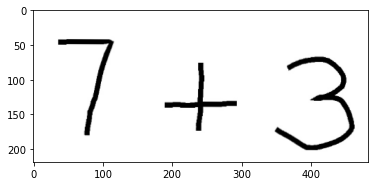

In [187]:
plt.imshow(image)

In [188]:
imgray = cv.cvtColor(image_working_copy, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

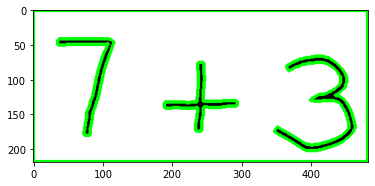

In [189]:
image_with_contours = cv.drawContours(image_working_copy, contours, -1, (0,255,0), 3)

plt.imshow(image_with_contours)

In [190]:
def find_contours(path):
    """
    Finds all contours in a given picture.
    Args:
        path (str): path to image
    Returns:
        contours: Detected contours. Each contour is stored as a vector of points.
        hierarchy: Optional output vector, containing information about the image topology.
    """
    img = cv.imread(path)
    imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    return cv.findContours(
        thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [191]:
contours, hierarchy = find_contours('sevenplusthree.png')

In [193]:
# create list of tuples
boundingRects = [cv.boundingRect(contour) for contour in contours]

In [211]:
boundingRects

[(0, 0, 483, 219), (189, 75, 106, 100), (348, 66, 117, 137), (35, 41, 82, 140)]

In [195]:
(x, y, w, h) = boundingRects[2]

In [196]:
rect_img = cv.rectangle(image_working_copy, (x-10, y-10), (x+w+10, y+h+10), (255, 0, 0), 3)

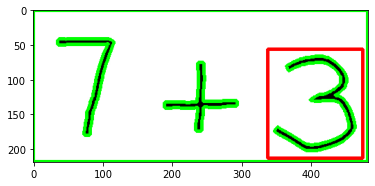

In [197]:
plt.imshow(rect_img)

In [198]:
def find_bounding_rects(image):
    """Finds all contours and chooses ones that best contour given characters.
    Args:
        image (np.ndarray): np.ndarray representation of the image
    Returns:
        list: list of bounding boxes for filtered contours
    """
    contours, hierarchy = find_contours(image)
    boundingRects = [cv.boundingRect(contour) for contour in contours]

    # If 2 bounding boxes are overlapping, take the bigger one
    for i in range(len(boundingRects)):
        if boundingRects[i] is None:
            continue
        for j in range(i + 1, len(boundingRects)):
            if boundingRects[j] is None:
                continue
            x1, y1, width1, height1 = boundingRects[i]
            x2, y2, width2, height2 = boundingRects[j]

            if overlapping_axes(x1, width1, x2, width2) and overlapping_axes(y1, height1, y2, height2):
                if width1 * height1 > width2 * height2:
                    boundingRects[j] = None
                else:
                    boundingRects[i] = None
                    break

    return [bounding for bounding in boundingRects if bounding is not None]

In [234]:
def crop_bounding_box(image, bounding_boxes):
    """Crops images given their bounding boxes
    Args:
        image (np.ndarray): np.ndarray representation of the image
        bounding_boxes (list): bounding box to be used for cropping
    Returns:
        np.ndarray: np.ndarray representation of the cropped image
    """
    cropped_images = list()
    
    for i in range(1, len(bounding_boxes)):
        x, y, width, height = bounding_boxes[i]
        cropped_image = image[(y-10):(y+height+10), (x-10):(x+width+10)]
        cropped_images.insert(0, cropped_image)
    
    return cropped_images

In [235]:
cropped_imgs = crop_bounding_box(image, boundingRects)

In [236]:
len(cropped_imgs)

3

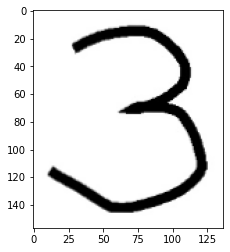

In [239]:
plt.imshow(cropped_imgs[1])

In [221]:
result=cv.imwrite(r'C:\Users\Korisnik\git_workspace\MathSolve\Handwritten equation processing\output\output1.jpg', cropped_img)
if result==True:
  print('File saved successfully')
else:
  print('Error in saving file')

File saved successfully
